In [1]:
import datetime as dt
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pandas_datareader import data as pdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from Lyapunov import *

In [2]:
df = pd.read_csv('VIX.csv')
df.index = np.arange(len(df))
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,24.940001,27.180000,24.799999,27.010000,27.010000,0
1,2000-01-05,27.980000,29.000000,25.850000,26.410000,26.410000,0
2,2000-01-06,26.680000,26.709999,24.700001,25.730000,25.730000,0
3,2000-01-07,25.139999,25.170000,21.719999,21.719999,21.719999,0
4,2000-01-10,21.889999,22.490000,21.360001,21.709999,21.709999,0
...,...,...,...,...,...,...,...
4772,2018-12-21,28.240000,31.350000,25.709999,30.110001,30.110001,0
4773,2018-12-24,29.290001,36.099998,29.160000,36.070000,36.070000,0
4774,2018-12-26,35.500000,36.200001,29.590000,30.410000,30.410000,0
4775,2018-12-27,31.200001,33.799999,29.660000,29.959999,29.959999,0


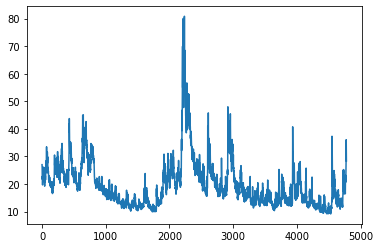

In [3]:
close = df.Close
plt.plot(close)

In [4]:
# Dimensionality parameters
L = 1   # step granularity
m = 10  # window size
q = 64  # number of neurons

In [5]:
def sliding_window(df, m, L): 
    slid_w = []
    targets = []
    for i,row in df.iterrows():
        if i + m*L < len(df.index):
            slid_w.append(list(df.loc[i:i+L*m-1:L,'Close']))
            targets.append(df.loc[i+m*L,'Close'])
    data = pd.DataFrame(slid_w)
    return data,targets

X, y = sliding_window(df, m, L)
y = pd.DataFrame(y, columns = ['target'])

In [6]:
scaler = StandardScaler()
scaler.fit(pd.concat([X, y]))
X = pd.DataFrame(scaler.transform(pd.concat([X, y], axis = 1)))

In [7]:
y = X.loc[:,10]
X = X.loc[:,:9]

In [8]:
model = Sequential([
  Dense(q, activation='tanh', input_shape=(m,)),  
  Dense(1),
])

model.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=['mse','mae'],
)

model.fit(X, np.asarray(y), epochs=1000, verbose = False, batch_size = 16)
model.evaluate(X, np.asarray(y))

149/149 [==============================] - 0s 547us/step - loss: 0.0307 - mse: 0.0307 - mae: 0.1130


[0.03071589767932892, 0.03071589767932892, 0.11303599178791046]

In [9]:
y_predict = pd.DataFrame(model.predict(X).reshape(1,-1)).T
y_predict.columns = ['target']
new_X = pd.concat([X, y_predict], axis = 1)
new_X = pd.DataFrame(scaler.inverse_transform(new_X))
new_y = new_X[m]

In [10]:
new_close = close[m:]
new_close.index = range(len(new_y))

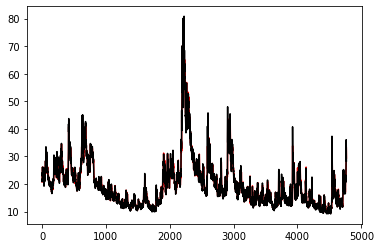

In [23]:
plt.plot(new_y[0:], c = 'red')
plt.plot(new_close[0:], c = 'black')

In [29]:
weights = model.get_weights()
weights = [model.layers[1].get_weights()[1], model.layers[0].get_weights()[0]]
model.layers[0].get_weights()[1]

array([ 8.4329722e-04, -3.4486733e-03,  4.9486579e-03, -9.1647708e-01,
        1.2025272e-03, -9.5918272e-03, -7.2327202e-05,  7.7443731e-01,
       -2.0314562e-03,  3.0420891e-03, -2.8774985e-03, -1.8596315e-01,
       -1.5743030e-02, -2.5368743e-03,  5.6604831e-04,  3.1970043e-03,
       -1.0366033e+00,  3.3926359e-01, -1.0760486e-03,  2.6481909e-01,
       -4.0376685e-03, -8.2571432e-03,  7.1565157e-01, -5.7174318e-04,
       -2.8780475e+00, -2.3138069e-03,  1.7463197e-03,  5.3355715e-04,
        1.1011310e+00, -4.7213919e-03,  4.1657463e-03, -1.6917104e-03,
        3.4899208e-01,  2.4487424e-01,  8.8605547e-01,  7.2073148e-05,
       -8.7346841e-04, -1.5090171e-03,  2.5184938e-01,  6.7769974e-01,
        8.2954299e-01, -3.2999008e-03,  2.1133758e-02,  1.0952968e-02,
       -2.8476089e-01,  3.1511458e-03, -4.1271341e-03,  3.1355461e-03,
        6.6328532e-01, -3.1433194e-03, -2.0871267e-03,  5.6682301e-01,
       -1.2956587e+00,  7.3884100e-01, -1.9174782e+00, -7.1888733e-01,
      

In [22]:
T=500
a=model.layers[1].get_weights()[0]
b=model.layers[0].get_weights()[0]
bi=model.layers[0].get_weights()[1]
l=Lyapunov (a,b,bi,y_predict,L,m,q,T)
print(l)

(0.002173145738287338+0j)


In [15]:
y_predict

,target
0,0.120551
1,0.234588
2,0.223721
3,0.163588
4,0.500836
...,...
4762,0.951041
4763,1.108358
4764,1.588523
4765,1.479014
